In [1]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
from tqdm import tqdm
import pandas as pd

from utils import fast_matrix_det, fast_quadratic_form, woodbury, rbf

$$
\newcommand{\GP}{\mathcal{GP}}
$$

# Problem: Toy non-linear regression

We are going to use the toy dataset from 
$$
\GP
$$

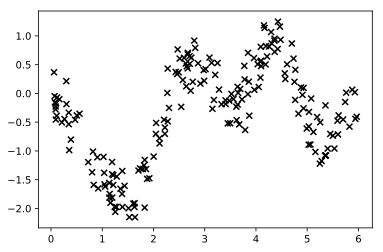

In [2]:
X_n = pd.read_csv('./data/train_inputs', header=None, sep='\s+').values
Y = pd.read_csv('./data/train_outputs', header=None, sep='\s+').values

plt.scatter(X_n, Y, marker='x', color='k')

In [3]:
def get_predictive_gp(X_n, Y, sigma_noise, sigma_f, length_scale):
    
    def mu_fn(x_pred):
        
        x_pred = x_pred.reshape((1, 1))
        K_ = rbf(np.concatenate((x_pred, X_n), axis=0), sigma_f, length_scale)
        
        K_xn = K_[:1, 1:]
        K_nn = K_[1:, 1:]
        
        prior_precision = np.linalg.inv(sigma_noise ** 2. * np.eye(len(X_n)) + K_nn)
        
        return np.dot(K_xn, np.dot(prior_precision, Y.reshape((-1, 1))))
    
    def cov_fn(x_pred):
        
        x_pred = x_pred.reshape((1, 1))
        K_ = rbf(np.concatenate((x_pred, X_n), axis=0), sigma_f, length_scale)
        
        K_xx = K_[:1, :1]
        K_xn = K_[:1, 1:]
        K_nn = K_[1:, 1:]
        
        prior_precision = np.linalg.inv(sigma_noise ** 2. * np.eye(len(X_n)) + K_nn)
        
        return K_xx - np.dot(np.dot(K_xn, prior_precision), K_xn.T)
    
    return mu_fn, cov_fn

In [4]:
def gp_log_prob(X_n, Y, sigma_noise, sigma_f, length_scale, verbose=False):
    
    n = len(X_n)
    
    K = rbf(X_n, sigma_f, length_scale)
    noise_cov = (sigma_noise ** 2.) * np.eye(n)
    
    Sigma = noise_cov + K
    
    det_gp_cov = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    
    log_prob = -n / 2. * np.log(2 * np.pi) \
                -0.5 * np.log(det_gp_cov) \
                -0.5 * np.dot(np.dot(Y.T, Sigma_inv), Y)
    
    if verbose:
        print("\n==================")
        print(det_gp_cov)
        print(log_prob)
        print("\n==================")
    
    return log_prob

In [5]:
def fit_regular(X_n, Y, log_sigma_noise=1., log_sigma_f=0., log_length_scale=0., learn_rate=1e-4, num_iter=10000, early_stopping_threshold=1e-3, verbose=True):
    
    prev = -np.inf
    
    log_every = 100
    
    log_prob_lambda = lambda log_sigma_noise_, log_sigma_f_, log_length_scale_: \
                       gp_log_prob(X_n, Y, np.exp(log_sigma_noise_), np.exp(log_sigma_f_), np.exp(log_length_scale_))
    
    theta = [log_sigma_noise, log_sigma_f, log_length_scale]
    dF_dtheta = [grad(log_prob_lambda, i) for i in range(len(theta))]

    for i in range(num_iter):

        grads = [dF_dtheta[j](*theta) for j in range(len(theta))]
        theta = [theta[j] + learn_rate * gradient for j, gradient in enumerate(grads)]
    
        log_prob = log_prob_lambda(*theta)
        
        if log_prob - prev > early_stopping_threshold:
            prev = log_prob
            
            yield tuple(theta)
            
        else:
            print("Early stopping after {} iterations with log-probabilitiy {:.4f}!".format(i, log_prob))
            break

-389.1207986043045
-105.81517509443404
-56.415587366714604
Early stopping after 272 iterations with log-probabilitiy -56.1328!


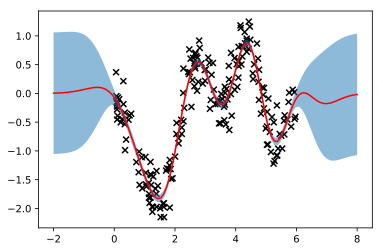

In [6]:
Y = Y.squeeze()

xs = np.linspace(-2., 8., 100)

for i, (log_sigma_noise, log_sigma_f, log_length_scale) in enumerate(fit_regular(X_n, Y)):
    
    if i % 100 == 0:
        print(gp_log_prob(X_n, Y, np.exp(log_sigma_noise), np.exp(log_sigma_f), np.exp(log_length_scale)))
        
mu_fn, cov_fn = get_predictive_gp(X_n, Y, np.exp(log_sigma_noise), np.exp(log_sigma_f), np.exp(log_length_scale))

mus = np.array([mu_fn(x) for x in xs])
stds = np.array([np.sqrt(cov_fn(x)) for x in xs])

plt.scatter(X_n, Y, marker='x', color='k')

plt.fill_between(xs, (mus-stds).squeeze(), (mus+stds).squeeze(), alpha=.5)

plt.plot(xs, mus.squeeze(), color='r')

plt.show()

In [47]:
def free_energy(X_n, X_m, Y, sigma_noise, sigma_f, length_scale, verbose=False):
    n = len(X_n)
    
    K = rbf(np.concatenate((X_n, X_m), axis=0), sigma_f, length_scale)
    
    K_nn = K[:n, :n]
    
    K_mm = K[n:, n:]
    K_mm_inv = np.linalg.inv(K_mm)
    #K_mm_inv = K_mm_inv + 1e-6 * np.eye(len(K_mm))
    
    K_nm = K[:n, n:]
    
    noise_cov_diag = (sigma_noise ** 2.) * np.ones(n)
    noise_cov = (sigma_noise ** 2.) * np.eye(n)
    
    gp_cov = np.dot(np.dot(K_nm, K_mm_inv), K_nm.T)
    det_gp_cov_slow = np.linalg.det(noise_cov + gp_cov)
    det_gp_cov = fast_matrix_det(noise_cov_diag, K_nm, K_nm.T, K_mm)
    #gp_cov_inv = woodbury(noise_cov_diag, K_nm, K_nm.T, K_mm)
    gp_QF = fast_quadratic_form(noise_cov_diag, K_nm, K_nm.T, K_mm, Y)
    
    log_prob_gaussian = -n / 2. * np.log(2 * np.pi) \
                        -0.5 * np.log(det_gp_cov) \
                        -0.5 * gp_QF
    
    regularising_term = 1. / (2 * sigma_noise ** 2.) * (np.trace(K_nn) - np.trace(gp_cov))
    
    if verbose:
        print("\n==================")
        #print(K_mm)
        print(np.linalg.det(noise_cov))
        print(np.linalg.det(K_mm_inv), det_gp_cov)
        print(det_gp_cov_slow)
        print(gp_QF)
        print(regularising_term)
        print(log_prob_gaussian)
        print("\n==================")
        
    return log_prob_gaussian - regularising_term

In [48]:
def get_predictive_variational_gp(X_m, X_n, Y, sigma_noise, sigma_f, length_scale):
    """
    """
    n = len(X_n)
    
    K = rbf(np.concatenate((X_n, X_m), axis=0), sigma_f, length_scale)
    
    K_nn = K[:n, :n]
    
    K_mm = K[n:, n:]
    K_mm_inv = np.linalg.inv(K_mm)
    #K_mm_inv = K_mm_inv + 1e-6 * np.eye(len(K_mm))
    
    K_nm = K[:n, n:]
    
    Sigma = np.linalg.inv(K_mm + sigma_noise ** -2. * np.dot(K_nm.T, K_nm))
    mu = sigma_noise ** -2. * np.dot(np.dot(Sigma, K_nm.T), Y.reshape(-1, 1))
    
    def mu_fn(x_pred):
        
        x_pred = x_pred.reshape((1, 1))
        K_ = rbf(np.concatenate((x_pred, X_m), axis=0), sigma_f, length_scale)
#         print(np.concatenate((x_pred, X_m), axis=0).shape)
#         print(X_m)
        K_xm = K_[:1, 1:]
        return np.dot(K_xm, mu)
    
    def cov_fn(x_pred):
        
        x_pred = x_pred.reshape((1, 1))
        K_ = rbf(np.concatenate((x_pred, X_m), axis=0), sigma_f, length_scale)
        K_xx = K_[:1, :1]
        K_xm = K_[:1, 1:]
        
        return K_xx - np.dot(np.dot(K_xm, K_mm_inv), K_xm.T) \
                + np.dot(np.dot(K_xm, Sigma), K_xm.T)
    
    return mu_fn, cov_fn

In [63]:
def fit_var(X_n, X_m, Y, 
            log_sigma_noise=0, 
            log_sigma_f=0., 
            log_length_scale=-1., 
            learn_rate=1e-4, 
            early_stopping_threshold=1e-4, 
            num_iter=1000,
            momentum=0.9,
            log_every = 100,
            verbose=True):
    
    prev = -np.inf

    
    F_lambda = lambda X_m_, log_sigma_noise_, log_sigma_f_, log_length_scale_: \
                   free_energy(X_n, X_m_, Y, np.exp(log_sigma_noise_), np.exp(log_sigma_f_), np.exp(log_length_scale_))
    
    theta = [X_m, log_sigma_noise, log_sigma_f, log_length_scale]
    dF_dtheta = [grad(F_lambda, i) for i in range(len(theta))]

    num_params = len(theta)
    
    prev_grads = [0] * num_params

    for i in range(1, num_iter + 1):

        #print(prev_grads[1:])
        theta_ = [theta[k] - momentum * prev_grads[k] for k in range(num_params)]
        
        grads = [dF_dtheta[j](*theta_) for j in range(num_params)]
        
        grads = [momentum * prev_grads[j] + learn_rate * gradient for j, gradient in enumerate(grads)]
        
        theta = [theta[j] + gradient for j, gradient in enumerate(grads)]
    
        #print(theta)
        prev_grads = grads
        
        F = F_lambda(*theta).squeeze()
        if F - prev > early_stopping_threshold:
            prev = F
            
            yield tuple(theta)
            
        else:
            print("Early stopping after {} iterations with F={:.4f}!".format(i, prev))
            break

(15, 1)
(200, 1)
[[-229.80014073]]
Early stopping after 7 iterations with F=-188.5332!


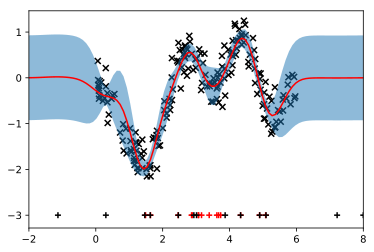

In [68]:
#X_m_init = np.linspace(2., 4., 15).reshape((-1, 1))
X_m_init = np.random.normal(loc=3., scale=1., size=15).reshape((-1, 1))
#X_m_init = np.random.uniform(low=2., high=4., size=15).reshape((-1, 1))
#print(X_m_init)
Y = Y.squeeze()
print(X_m_init.shape)
print(X_n.shape)

xs = np.linspace(-2., 8., 100)

plt.xlim([-2., 8.])

plt.scatter(X_m_init, -3 * np.ones_like(X_m_init), marker='+', color='r')

for i, (X_m, log_sigma_noise, log_sigma_f, log_length_scale) in enumerate(fit_var(X_n, X_m_init, Y)):
    
    if i % 100 == 0:
        print(free_energy(X_n, X_m, Y, np.exp(log_sigma_noise), np.exp(log_sigma_f), np.exp(log_length_scale)))
        #print(X_m.squeeze())
        
mu_fn, cov_fn = get_predictive_variational_gp(X_m, X_n, Y, np.exp(log_sigma_noise), np.exp(log_sigma_f), np.exp(log_length_scale))

mus = np.array([mu_fn(x) for x in xs])
stds = np.array([np.sqrt(cov_fn(x)) for x in xs])

plt.scatter(X_n, Y, marker='x', color='k')

plt.scatter(X_m, -3 * np.ones_like(X_m), marker='+', color='k')

plt.fill_between(xs, (mus-stds).squeeze(), (mus+stds).squeeze(), alpha=.5)

plt.plot(xs, mus.squeeze(), color='r')

plt.show()

In [56]:
a = np.eye(3000)
b = np.random.random((3000, 4))
d = np.random.random((4, 4))
c = np.random.random((4, 3000))
d_inv = np.linalg.inv(d)

m = a + np.dot(np.dot(b, d_inv), c)

m_inv = np.linalg.inv(m)
#print(woodbury(np.ones(10), b, c, d))
#print(m_inv)

ys = np.ones(3000)

a_diag = np.ones(3000)

%time print(np.dot(np.dot(ys.reshape(1, -1), np.linalg.inv(m)), ys.reshape(-1, 1)))
%time print(fast_quadratic_form(a_diag, b, c, d, ys))
print("\n")

%time print(np.linalg.det(m))
%time print(fast_matrix_det(a_diag, b, c, d))

print("\n")

print(np.sum(np.abs(np.linalg.inv(m) - woodbury(a_diag, b, c, d))))

[[41.49203837]]
CPU times: user 2.31 s, sys: 146 ms, total: 2.45 s
Wall time: 1.41 s
[[41.49203837]]
CPU times: user 1.47 ms, sys: 465 µs, total: 1.94 ms
Wall time: 915 µs


-607264.9656673977
CPU times: user 583 ms, sys: 44 ms, total: 627 ms
Wall time: 316 ms
-607264.9656672121
CPU times: user 1.01 ms, sys: 219 µs, total: 1.23 ms
Wall time: 588 µs


1.0100811322653416e-06
